<a href="https://colab.research.google.com/github/Hrithik2212/PyTorch-Deep-Learning-/blob/main/04_CNN_on_Custom_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Classification with Torch Vision 

In [1]:
!nvidia-smi

Wed Aug 10 11:56:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Wrangling 

In [2]:
# The dataset is a subset of 101 food data set 
import requests
import zipfile 
from pathlib import Path 
data_path = Path('data/')
img_path = data_path / 'pizza_steak_sushi'

if img_path.is_dir():
  print(f'Image Path exists ')
else :
  print(f'Image Path does not exist')
  print(f'Downloading Data')
  img_path.mkdir(parents=True , exist_ok=True)
  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...") 
    zip_ref.extractall(img_path)

Image Path does not exist
Unzipping pizza, steak, sushi data...


In [6]:
import os 
def walk_through_dir(dir_path):
  for dirpath , dirnames , filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} in {dirpath}')
walk_through_dir('/content/data')

There are 2 directories and 0 in /content/data
There are 2 directories and 0 in /content/data/pizza_steak_sushi
There are 3 directories and 0 in /content/data/pizza_steak_sushi/test
There are 0 directories and 19 in /content/data/pizza_steak_sushi/test/steak
There are 0 directories and 31 in /content/data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 in /content/data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 in /content/data/pizza_steak_sushi/train
There are 0 directories and 75 in /content/data/pizza_steak_sushi/train/steak
There are 0 directories and 72 in /content/data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 in /content/data/pizza_steak_sushi/train/pizza
There are 0 directories and 0 in /content/data/.ipynb_checkpoints


In [7]:
train_dir = img_path / 'train'
test_dir = img_path / 'test'
train_dir , test_dir 

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Data Exploration 

### Visualizing 

Random Image Path data/pizza_steak_sushi/train/steak/2614189.jpg
Image Class steak
Image Height 512
Imahe Width  512


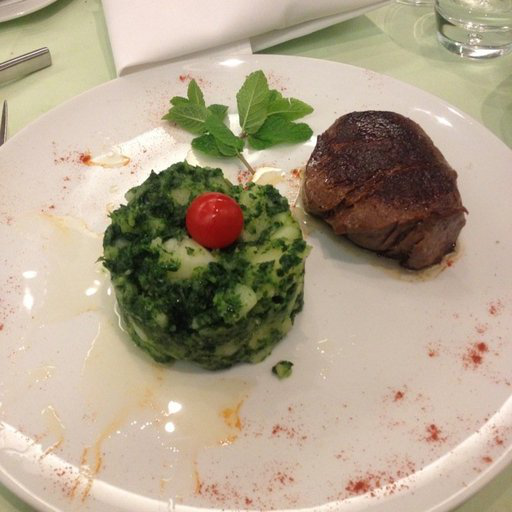

In [15]:
import random 
from PIL import Image 

image_path_list = list(img_path.glob('*/*/*.jpg'))
rand_img_path = random.choice(image_path_list)

image_class = rand_img_path.parent.stem

img = Image.open(rand_img_path)

print(f'Random Image Path {rand_img_path}')
print(f'Image Class {image_class}')
print(f'Image Height {img.height}')
print(f'Imahe Width  {img.width}' )
img

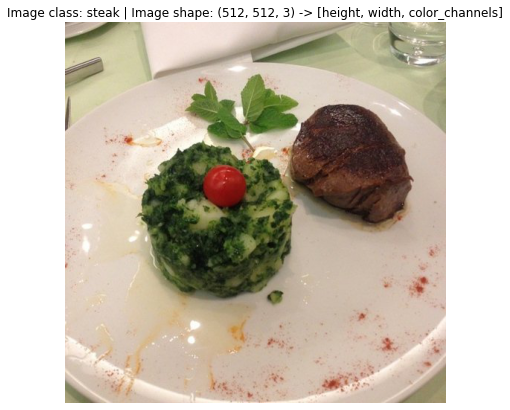

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

### Turn imgs to Tensors

In [17]:
import torch 
# device agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [21]:
from torchvision import transforms , datasets 

data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor()
])
data_transform 

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
    RandomHorizontalFlip(p=0.4)
    ToTensor()
)

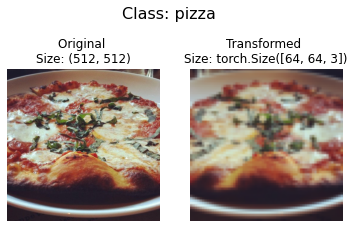

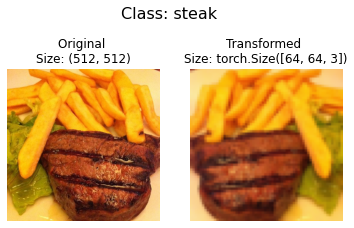

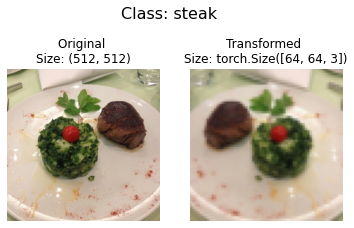

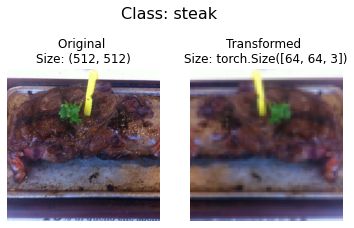

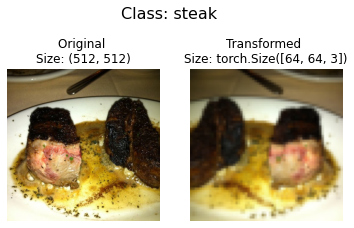

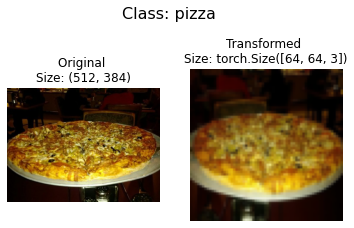

In [23]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=6)

## Data Preparation

In [24]:
from torchvision import datasets 

train_data = datasets.ImageFolder(root = str(train_dir),
                                  transform = data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root = str(test_dir),
                                 transform = data_transform,)

print(f'Train Data \n {train_data}')
print(f'Test Data \n {test_data}')

Train Data 
 Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.4)
               ToTensor()
           )
Test Data 
 Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.4)
               ToTensor()
           )


In [25]:
class_names = train_data.classes
class_names 

['pizza', 'steak', 'sushi']

In [26]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [27]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

## Building Model

### Model 0 : TinyVGG without Data augmentation

In [83]:
simple_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [84]:
from torch.utils.data import DataLoader
train_data_simple = datasets.ImageFolder(root = str(train_dir),
                                         transform=simple_transforms,
                                         target_transform=None)
test_data_simple = datasets.ImageFolder(root = str(test_dir),
                                        transform = simple_transforms)



BATCH_SIZE =32 
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

train_dl_simple = DataLoader(train_data_simple,
                             batch_size = BATCH_SIZE,
                             shuffle = True , 
                             num_workers = NUM_WORKERS)

test_dl_simple = DataLoader(test_data,
                            batch_size = BATCH_SIZE, 
                             num_workers = NUM_WORKERS)

train_dl_simple, test_dl_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7fc6cc3d7b90>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc6cc3d7750>)

In [85]:
from torch.nn.modules.pooling import MaxPool2d
from torch import nn
class TinyVGG(nn.Module):
  def __init__(self,input:int,hidden_dim:int,output:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
                nn.Conv2d(in_channels =input,
                          out_channels = hidden_dim ,
                          kernel_size =3 ,
                          stride = 1 , 
                          padding =1),
                nn.ReLU(),
                nn.Conv2d(in_channels = hidden_dim,
                          out_channels=hidden_dim,
                          kernel_size=3,
                          stride =1 ,
                          padding =1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,stride=2)
                )
    
    self.conv_block_2 = nn.Sequential(
                nn.Conv2d(in_channels=hidden_dim,
                          out_channels = hidden_dim,
                          kernel_size=3,
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels = hidden_dim,
                          out_channels = hidden_dim , 
                          kernel_size = 3 ,
                          padding =1),
                nn.ReLU(),
                nn.MaxPool2d(2)
                )
    
    self.dense_1 = nn.Sequential(
                nn.Flatten(),
                nn.Linear(in_features=hidden_dim*16*16,
                          out_features=output)
    )

  def forward(self,X):
    return self.dense_1(self.conv_block_2(self.conv_block_1(X)))


In [86]:
Model_0 = TinyVGG(input = 3,
                  hidden_dim =10,
                  output = len(train_data.classes)).to(device)
Model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [87]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(Model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [88]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [89]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [90]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [91]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=Model_0.parameters(), lr=0.1)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=Model_0, 
                        train_dataloader=train_dl_simple,
                        test_dataloader=test_dl_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 54.3200 | train_acc: 0.4141 | test_loss: 12.0506 | test_acc: 0.2604
Epoch: 2 | train_loss: 2.8401 | train_acc: 0.4258 | test_loss: 1.2159 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0873 | train_acc: 0.4258 | test_loss: 1.1924 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1288 | train_acc: 0.3047 | test_loss: 1.1619 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0947 | train_acc: 0.4258 | test_loss: 1.1510 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.0973 | train_acc: 0.3047 | test_loss: 1.1444 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.0872 | train_acc: 0.4023 | test_loss: 1.1528 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1237 | train_acc: 0.2930 | test_loss: 1.1652 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1263 | train_acc: 0.2930 | test_loss: 1.1444 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.0913 | train_acc: 0.4258 | test_loss: 1.0814 | test_acc: 0.2604
Epoch: 11 | train_loss: 1.0872 | train_acc: 0.4258 | test_loss: 1.1012 | test_acc: 0.2604
Epoch: 12 | train